# Проект: Линейные модели в машинном обучении

## 1. Введение

   Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

   Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. 

Необходимо создать две прогнозные модели для отбора бурёнок в поголовье:

- Первая будет прогнозировать возможный удой коровы (целевой признак **Удой**);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак **Вкус молока**).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным;

## 2. Загрузка и изучение данных

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix


RANDOM_STATE = 42
sns.set()


### 2.1 Загрузка данных

In [55]:
df_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', ';')
df_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', ';')
df_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', ';')

Загрузил данные в датасеты df_main, df_dad, df_buy для файлов ferma_main.csv, ferma_dad.csv, cow_buy.csv

### 2.2 Изучение данных

In [56]:
df_main.columns = ['id',
 'удой',
 'эке',
 'сырой_протеин',
 'спо',
 'порода',
 'тип_пастбища',
 'порода_папы_быка',
 'жирность',
 'белок',
 'вкус_молока',
 'возраст']
df_dad.columns = ['id', 'имя_папы']
df_buy.columns = ['порода',
 'тип_пастбища',
 'порода_папы_быка',
 'имя_папы',
 'жирность',
 'белок',
 'возраст']
display(df_main.head(5))
display(df_dad.head(5))
display(df_buy.head(5))

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Переименовал колонки для всех трех датасетов по следующим правилам:
- приведение к нижнему регистру
- удаление упоминания по единицах измерения в конце имени колонки
- пробел заменется на подчеркивание
- имена колонок **текущая_жирность** и **текущий_уровень_белка** приведены к более общей форме **жирность** и **белок**

  Сейчас имена колонок приведены к единому стандарту.
  На первый взгляд содержимое колонок соответствует их наименованию.

## 3. Предобработка данных

In [57]:
df_main.info()
df_dad.info()
df_buy.info()
df_main_float_col_list = ['эке', 'спо', 'жирность', 'белок']
df_main_cat_col_list = ['вкус_молока', 'возраст', 'тип_пастбища']
df_main_str_col_list = ['порода', 'порода_папы_быка']
df_main['тип_пастбища'] = df_main['тип_пастбища'].str.lower()
df_main['тип_пастбища'] = df_main['тип_пастбища'].replace('равнинные', 'равнинное')
df_main['порода_папы_быка'] = df_main['порода_папы_быка'].replace('Айдиалл', 'Айдиал')
df_main.drop(df_main.loc[df_main['удой']==45616].index, inplace=True)
df_main[df_main_float_col_list]  = df_main[df_main_float_col_list].replace(',', '.', regex=True).astype('float')
df_main[df_main_cat_col_list]  = df_main[df_main_cat_col_list].astype('category')
df_main[df_main_str_col_list]  = df_main[df_main_str_col_list].astype('string')
print(df_main['тип_пастбища'].unique())
print(df_buy['тип_пастбища'].unique())
df_dad['имя_папы'] = df_dad['имя_папы'].astype('string')
df_buy_float_col_list = ['жирность', 'белок']
df_buy_cat_col_list = ['возраст', 'тип_пастбища']
df_buy_str_col_list = ['порода', 'порода_папы_быка', 'имя_папы']
df_buy[df_buy_float_col_list]  = df_buy[df_buy_float_col_list].replace(',', '.', regex=True).astype('float')
df_buy[df_buy_cat_col_list]    = df_buy[df_buy_cat_col_list].astype('category')
df_buy[df_buy_str_col_list]    = df_buy[df_buy_str_col_list].astype('string')
display(df_main.head(5))
display(df_dad.head(5))
display(df_buy.head(5))
df_main.info()
df_dad.info()
df_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                634 non-null    int64 
 1   удой              634 non-null    int64 
 2   эке               634 non-null    object
 3   сырой_протеин     634 non-null    int64 
 4   спо               634 non-null    object
 5   порода            634 non-null    object
 6   тип_пастбища      634 non-null    object
 7   порода_папы_быка  634 non-null    object
 8   жирность          634 non-null    object
 9   белок             634 non-null    object
 10  вкус_молока       634 non-null    object
 11  возраст           634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 n

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                633 non-null    int64   
 1   удой              633 non-null    int64   
 2   эке               633 non-null    float64 
 3   сырой_протеин     633 non-null    int64   
 4   спо               633 non-null    float64 
 5   порода            633 non-null    string  
 6   тип_пастбища      633 non-null    category
 7   порода_папы_быка  633 non-null    string  
 8   жирность          633 non-null    float64 
 9   белок             633 non-null    float64 
 10  вкус_молока       633 non-null    category
 11  возраст           633 non-null    category
dtypes: category(3), float64(4), int64(3), string(2)
memory usage: 51.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  -

Первичный анализ датасетов с помощью метода **info** показал, что почти все поля (кроме индексного и нескольких других)  имеют тип **object**, хотя их реальные типы float, category, string. Были выполнены приведения типов этих полей к трем вышеуказанным, при этом были еще проведены ряд преобразований:
- во всех колонках, содержащих числа с плавающей точкой, была заменена , на . как символ разделителя целой и дробной части
- содержимое колонки **тип_пастбища** в df_main было приведено к нижнему регистру, чтобы соотвествовать формату данных в этой же колонке в датасете df_buy
- в колонке **тип_пастбища** в df_main была произведена замена значений **равнинные** на **равнинное**, чтобы соответствовать набору из двух значений в этой категории:
    - равнинное
    - холмистое
- в колонке **порода_папы_быка** в df_main была произведена замена значений **Айдиалл** на **Айдиал**, чтобы соответствовать набору из двух значений в этой категории:
    - Айдиал
    - Соверин

Окончательный анализ на этой стадии показал, что датасеты не имеют пропусков, и колонки в них имеют тип, соответствующий их содержанию.

## 4. Исследовательский анализ данных

### 4.1 Cтатистический анализ всех признаков

In [58]:
print('Статистика количественных параметров для df_main')
display(df_main[df_main.columns.difference(['id'])].describe().T)
cols = [c for c in df_main.columns if df_main[c].dtype.name  in ['string', 'category']]
print('Статистика категориальных параметров для df_main')
display(df_main[cols].describe())
print('Статистика категориальных параметров для df_dad')
display(df_dad[df_dad.columns.difference(['id'])].describe().T)
print('Статистика количественных параметров для df_buy')
display(df_buy.describe().T)
cols = [c for c in df_buy.columns if df_buy[c].dtype.name  in ['string', 'category']]
print('Статистика категориальных параметров для df_buy')
display(df_buy[cols].describe())

print(list(df_main['порода_папы_быка'].unique()))
print(list(df_buy['порода_папы_быка'].unique()))

print(list(df_main['порода'].unique()))
print(list(df_buy['порода'].unique()))

Статистика количественных параметров для df_main


,count,mean,std,min,25%,50%,75%,max
белок,633.0,3.075665,0.002542,3.069,3.074,3.076,3.077,3.085
жирность,633.0,3.604550,0.167456,2.990,3.590,3.650,3.720,3.750
спо,633.0,0.912828,0.032227,0.840,0.890,0.930,0.940,0.960
сырой_протеин,633.0,1923.074250,182.270289,1660.000,1773.000,1881.000,2059.000,2349.000
удой,633.0,6124.736177,474.172345,5204.000,5751.000,6130.000,6501.000,7222.000
эке,633.0,14.547551,1.296684,10.900,13.500,14.700,15.600,16.800


Статистика категориальных параметров для df_main


,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст
count,633,633,633,633,633
unique,2,2,2,2,2
top,Вис Бик Айдиал,холмистое,Айдиал,вкусно,более_2_лет
freq,372,355,317,370,523


Статистика категориальных параметров для df_dad


,count,unique,top,freq
имя_папы,629,4,Барин,240


Статистика количественных параметров для df_buy


,count,mean,std,min,25%,50%,75%,max
жирность,20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
белок,20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


Статистика категориальных параметров для df_buy


,порода,тип_пастбища,порода_папы_быка,имя_папы,возраст
count,20,20,20,20,20
unique,2,2,2,4,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,более_2_лет
freq,11,11,12,8,15


['Айдиал', 'Соверин']
['Айдиал', 'Соверин']
['Вис Бик Айдиал', 'РефлешнСоверинг']
['Вис Бик Айдиал', 'РефлешнСоверинг']


Статанализ количественных и категориальных параметров для датасетов **df_main, df_dad, df_buy** показал:

    - количественные признаки показывают характер нормального распределения (более подробно можно будет сказать после анализа графиков)
    - категориальные признаки показывают наличие определенных категорий и количество уникальных значений этих категорий соответствует количеству уникальных значений в других таблицах
  

### 4.2 Построение графиков для каждого признака

#### 4.2.1 df_main количественные параметры

Index(['белок', 'жирность', 'спо', 'сырой_протеин', 'удой', 'эке'], dtype='object')


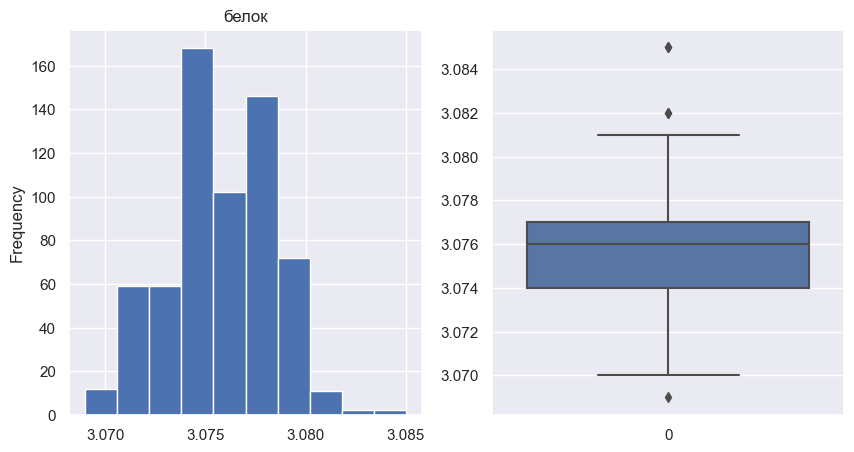

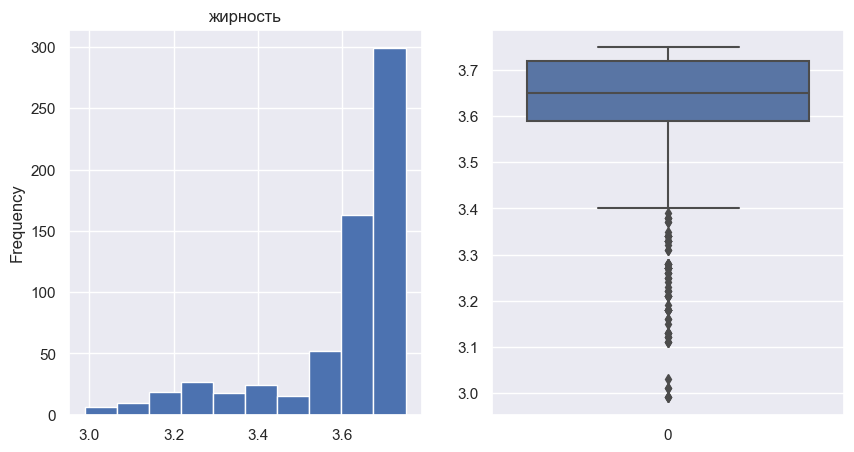

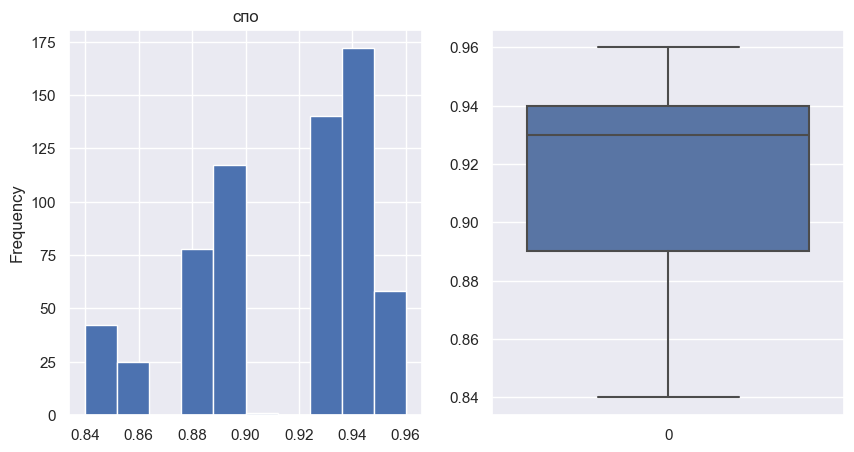

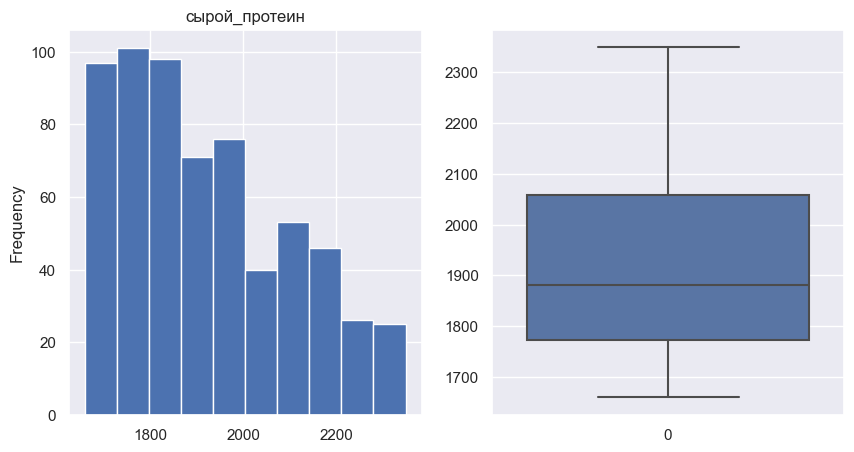

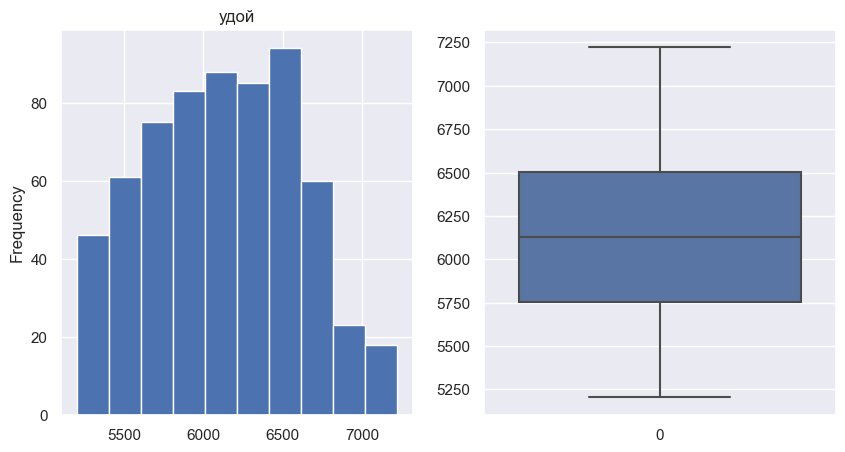

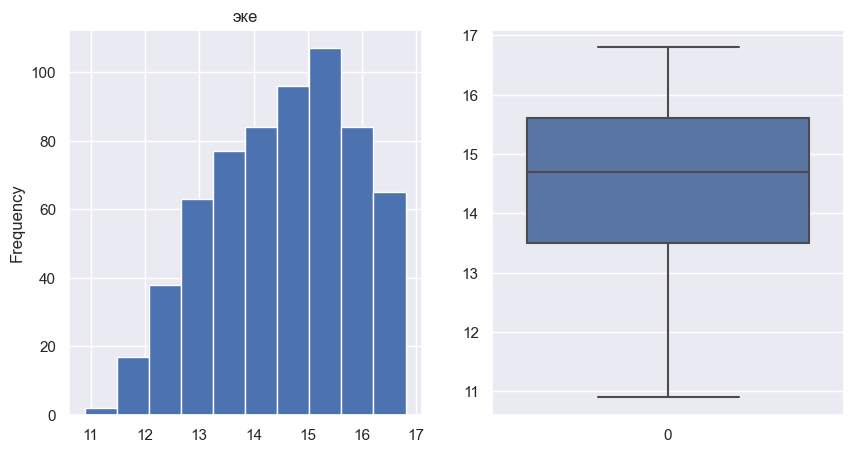

In [61]:
#cols = [c for c in df_main.columns if df_main[c].dtype.name not in ['string', 'category'] and c != 'id']
def plot_sub_plot_hist(df):
    for col in df.columns:
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(data=df[col], ax = axes[1])
        plt.show()
        
df_main_numeric = df_main.select_dtypes(include=np.number)
df_main_numeric = df_main_numeric[df_main_numeric.columns.difference(['id'])]
print(df_main_numeric.columns)
plot_sub_plot_hist(df_main_numeric)


Для количественных параметров - **'белок', 'жирность', 'спо', 'сырой_протеин', 'удой', 'эке'**. Для каждой колонки были построены гистограмма (с дефолтовым количеством бинов) и boxplot. Для колонки **удой** имеет место большой выброс = 45616 в единичном экземпляре, который принят за ошибку ввода данных и удален (Изменения внесены в п 3. Предобработка данных). Остальные распределения выглядят нормально, распределения **эке** и **белок** близки к нормальному, остальные - нет. Для параметра **жирность** имеют место выбросы ниже первого квантиля, для параметра **белок** имеет место небольшое количество выбросов, для остальных выбросов нет.


#### 4.2.2 df_main категориальные параметры

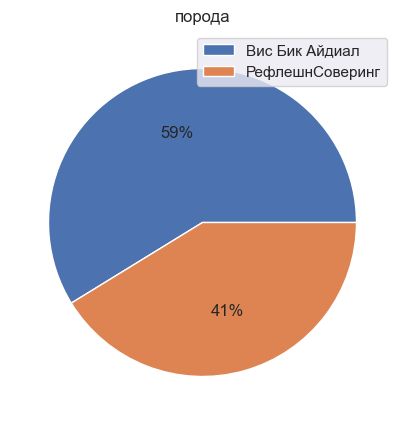

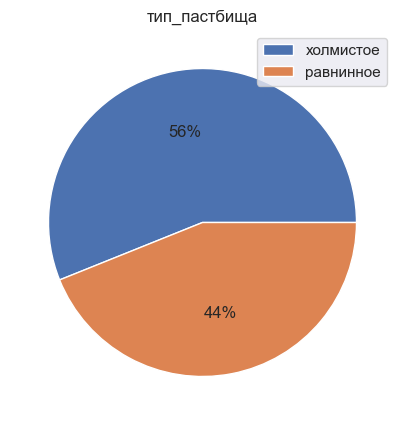

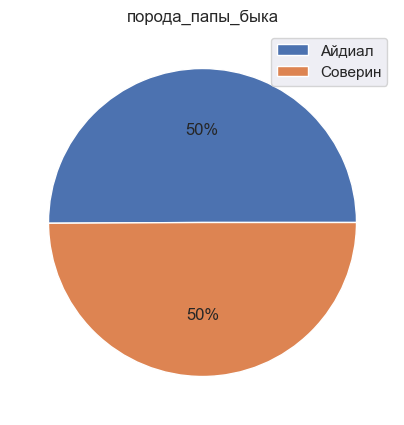

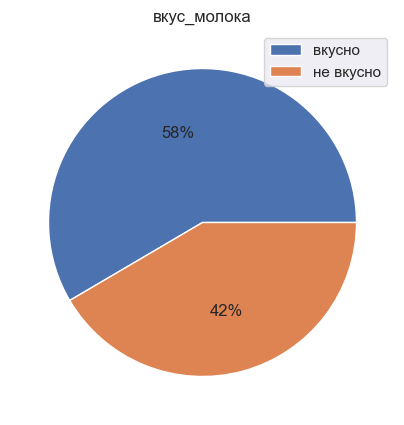

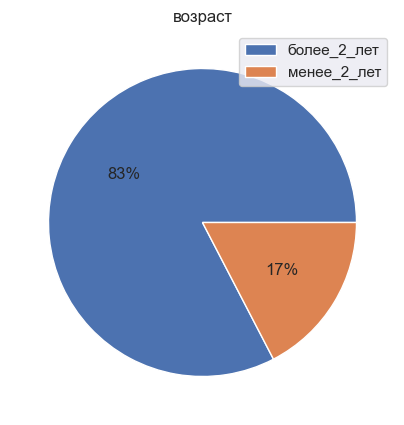

In [69]:
def plot_pie_plot_for_columns(df):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.show()

df_main_notnumeric = df_main.select_dtypes(exclude=np.number)
plot_pie_plot_for_columns(df_main_notnumeric)

### 4.3 Выводы о данных

## 5. Проведение корреляционного анализа признаков в датасете **ferma_main.csv**

### 5.1 Изучение взаимосвязи между признаками

### 5.2 Построение диаграммы рассеяния

### 5.3 Выводы о взаимосвязи признаков

## 6. Задача регрессии

### 6.1 Первая модель регрессии

### 6.2 Вторая модель регрессии

### 6.3 Третья модель регрессии

### 6.4 Сравнение качества трёх моделей линейной регрессии

### 6.5 Выбор лучшей модели и прогноз характеристики **Удой**

## 7. Задача классификации

### 7.1 Обучение модели LogisticRegression

### 7.2 Анализ модели LogisticRegression

### 7.3 С помощью обученной модели LogisticRegression спрогнозировать параметр **Вкус молока** коров, которых фермер хочет купить.

## 8. Выводы